In [39]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest

### Create a balanced dataset 

In [149]:
############ USER ############
balanced = True
cut = ''#bazin_cut_

name_1 = f'ELASTICC_TRAIN_SNIa-SALT2_{cut}features'
name_2 = f'ELASTICC_TRAIN_SNIb+HostXT_V19_{cut}features'
############ USER ############


# Create Bazin data
features_1 = pd.read_parquet(f'bazin_features/{name_1}.parquet')
features_1['target']='Ia'
features_2 = pd.read_parquet(f'bazin_features/{name_2}.parquet')
features_2['target']='Ib'

if balanced:
    nobj = min(len(features_1), len(features_2))
    bazin_features = pd.concat([features_1[:nobj], features_2[:nobj]])
    
else:
    bazin_features = pd.concat([features_1, features_2])

    
# Create Kostya data
features_1 = pd.read_parquet(f'features/{name_1}.parquet')
features_1['target']='Ia'
features_2 = pd.read_parquet(f'features/{name_2}.parquet')
features_2['target']='Ib'

if balanced:
    kostya_features = pd.concat([features_1[:nobj], features_2[:nobj]])
    
else:
    kostya_features = pd.concat([features_1, features_2])

### Add 1 % of anomalies

In [159]:
name_3 = f'ELASTICC_TRAIN_uLens-Binary_{cut}features'
ratio_anomaly = 1
target_ano = 'uLens-Binary'


# Create Bazin anomalies
features_3 = pd.read_parquet(f'bazin_features/{name_3}.parquet')
features_3['target']=target_ano
bazin_anomalies = pd.concat([bazin_features, features_3.sample(frac=0.01, random_state=42)], ignore_index=True)


# Create Kostya anomalies
features_3 = pd.read_parquet(f'features/{name_3}.parquet')
features_3['target']=target_ano
kostya_anomalies = pd.concat([kostya_features, features_3.sample(frac=0.01, random_state=42)], ignore_index=True)

### Use Isolation forest

In [160]:
n_anomalies = int(ratio_anomaly*len(bazin_features))

ano_list_bazin = [0]
ano_list_kostya = [0]

methods = [[bazin_anomalies, 'Bazin', ano_list_bazin],\
           [kostya_anomalies, 'Kostya', ano_list_kostya]]


for features in methods:
    
    clf = IsolationForest(random_state=42).fit(features[0].iloc[:, :-1])
    scored = features[0].copy()
    scored['score'] = clf.decision_function(features[0].iloc[:, :-1])
    indexes = scored.sort_values('score').iloc[:n_anomalies].index
    anomalies = features[0].iloc[indexes]
    
    nb_true_anomaly = (anomalies['target']==target_ano).sum()
    
    print(features[1])
    print(f'{nb_true_anomaly*100/n_anomalies:.2f} % of the top {ratio_anomaly*100} % score are actual {target_ano}')
    
    #Compute cumulative number of anomalies
    
    start = 0
    
    for i in anomalies['target']:
        if i == target_ano:
            start += 1
        features[2].append(start)

Bazin
0.13 % of the top 100 % score are actual uLens-Binary
Kostya
0.13 % of the top 100 % score are actual uLens-Binary


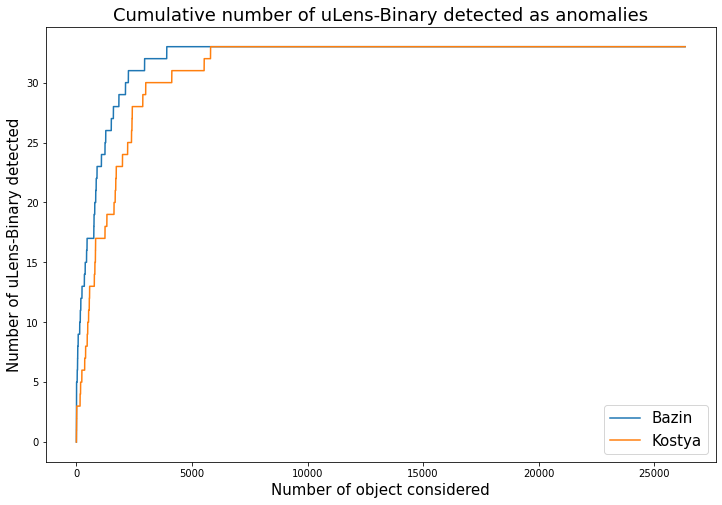

In [161]:
x = np.arange(0, n_anomalies+1)


plt.figure(figsize = (12,8))

plt.plot(x, ano_list_bazin, label='Bazin')
plt.plot(x, ano_list_kostya, label='Kostya')
plt.xlabel('Number of object considered', fontsize = 15)
plt.ylabel(f'Number of {target_ano} detected', fontsize = 15)
plt.title(f'Cumulative number of {target_ano} detected as anomalies', fontsize = 18)
plt.legend(fontsize=15)

In [162]:
n_anomalies

26336